In [22]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns


def loss_function(beta, X, y):
    return np.linalg.norm(y - X @ beta) ** 2


def l2_error(beta, beta_star):
    return np.linalg.norm(beta - beta_star)


def gradient(beta, X, y, t, lambda_val):
    grad = 2 * X.T @ (X @ beta - y) + (2 / t) * beta / (lambda_val**2 - beta**2)

    return grad

In [10]:
import jax.numpy as jnp
import jax

In [23]:
def loss(beta, X, y, t, lambda_val):
    loss = jnp.linalg.norm(y - X @ beta) ** 2 - (1 / t) * jnp.sum(
        jnp.log(lambda_val - beta) + jnp.log(lambda_val + beta)
    )
    return loss


loss_grad = jax.grad(loss, argnums=0)

In [41]:
n = 4
d = 6

beta = np.random.randn(d)
X = np.random.randn(n, d)
y = np.random.randn(n)
t = 1000
lambda_val = 2

gradient(beta, X, y, t, lambda_val), loss_grad(beta, X, y, t, lambda_val)

(array([ 17.47872034,   1.4624808 ,   2.86630325,  -2.03026064,
          0.09482558, -11.34767914]),
 Array([ 17.47872   ,   1.4624807 ,   2.866303  ,  -2.0302603 ,
          0.09482525, -11.347678  ], dtype=float32))

In [33]:
def optimize_sparse_regression(
    X, y, beta_star, lambda_val, t, lr, beta1, beta2, method="GD", epochs=10000
):
    n, d = X.shape
    beta = np.zeros(d)
    loss_trajectory = []
    error_trajectory = []

    if method == "adam":
        m = np.zeros(d)
        v = np.zeros(d)
        epsilon = 1e-8

    for epoch in range(epochs):
        # Record loss and error
        loss_trajectory.append(loss_function(beta, X, y))
        error_trajectory.append(l2_error(beta, beta_star))

        grad = gradient(beta, X, y, t, lambda_val)

        if method == "GD":
            ## YOUR CODE
            beta = beta - lr * grad

        elif method == "adam":
            ## YOUR CODE
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * grad**2
            beta = beta - lr * m / np.sqrt(v + epsilon)

    return beta, loss_trajectory, error_trajectory


# Plotting
def plot_trajectories(loss_trajectory, error_trajectory, title, save_fig=False):
    sns.set_context("paper")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_trajectory)
    plt.title(f"Loss Trajectory: {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")

    plt.subplot(1, 2, 2)
    plt.plot(error_trajectory)
    plt.title(f"L2 Error Trajectory: {title}")
    plt.xlabel("Epoch")
    plt.ylabel("L2 Error")
    plt.yscale("log")

    plt.tight_layout()

    if save_fig:
        plt.savefig(
            "figure_" + title + ".pdf", dpi=300, bbox_inches="tight", pad_inches=0
        )

    plt.show()

In [37]:
n = 100
d = 100
np.random.seed(0)

# Example usage:
X = np.random.randn(n, d)
beta_star = np.zeros(d)
beta_star[:5] = 1
y = X.dot(beta_star)


# Task 1: Solve using CVXPY
lambda_val = 2
beta_cvx = cp.Variable(d)
objective = cp.Minimize(cp.norm2(y - X @ beta_cvx) ** 2)
constraints = [cp.norm(beta_cvx, "inf") <= lambda_val]
problem = cp.Problem(objective, constraints)
problem.solve()

In [39]:
t = 10000
lr = 1e-3
beta1 = 0.9
beta2 = 0.9


# Example usage
beta_gd, loss_gd, error_gd = optimize_sparse_regression(
    X, y, beta_star, lambda_val, t, lr, beta1, beta2, method="GD"
)
beta_adam, loss_adam, error_adam = optimize_sparse_regression(
    X, y, beta_star, lambda_val, t, lr, beta1, beta2, method="adam"
)

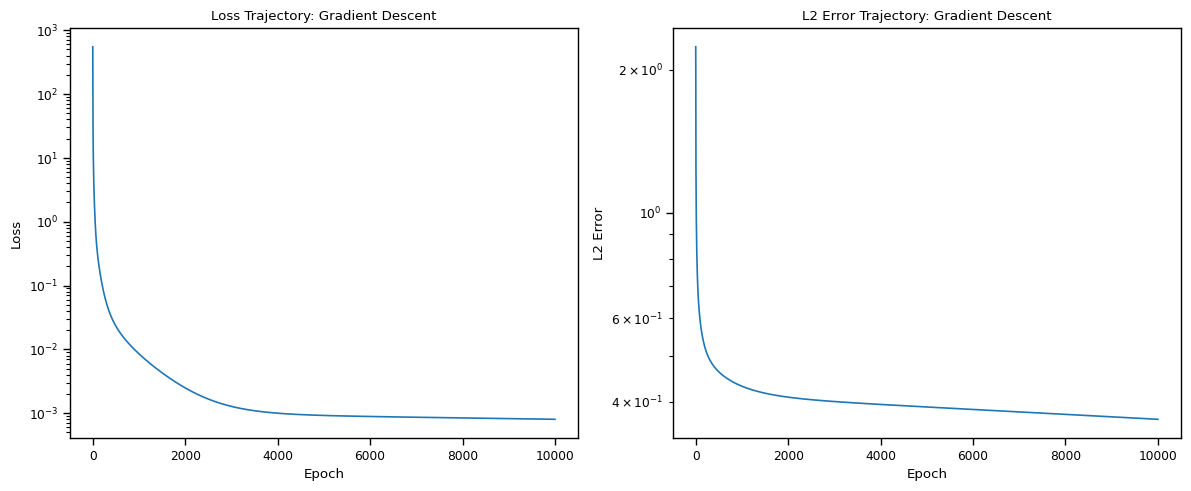

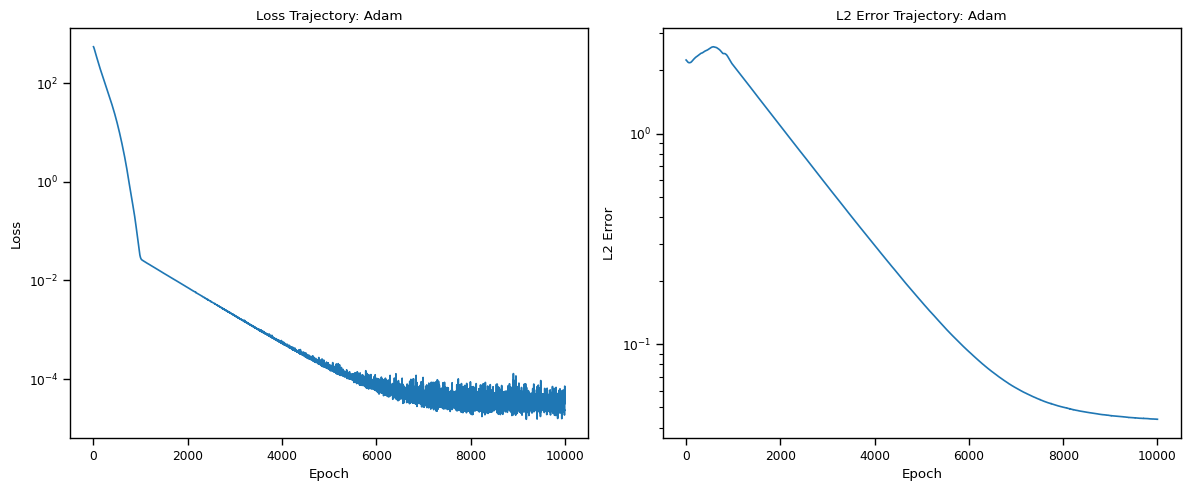

Error of Convex optimization from CVXPY: 
1.4734160024417833e-05
Error of Barrier Method from Gradient Descent: 
0.36740475369989434
Error of Barrier Method from Adam: 
0.04392511391227343


In [40]:
plot_trajectories(loss_gd, error_gd, "Gradient Descent", save_fig=True)
plot_trajectories(loss_adam, error_adam, "Adam", save_fig=True)


print(
    f"Error of Convex optimization from CVXPY: \n{l2_error(beta_cvx.value, beta_star)}"
)
print(
    f"Error of Barrier Method from Gradient Descent: \n{l2_error(beta_gd, beta_star)}"
)
print(f"Error of Barrier Method from Adam: \n{l2_error(beta_adam, beta_star)}")